# Developing the Capacity Model

## Overview 

This notebook contains the code to develop the capacity model. 

Initially 3 different models are compared (Linear regression, Random Forest regresstion, Gradient Boosted regression).

Hyper-parameters of the best model are fine-tunes to maximise performance in unseen data while preventing over-fitting and minimising model complexity

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('../data/master_scaled.csv', index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4


In [6]:
dta.shape

(1425, 12)

### Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1425, 13)

## Model Comparison

Features in the dataset that measure service capacity are:

- *gp_appt_available*: the number of GP appointments available per 10,000 people per month
- *111_111_offered*: the number of 111 calls offered (i.e. that the service can answer) per 10,000 people per month
- *amb_sys_answered*: the number of calls answered by the ambulance system per 10,000 people per month

### Pair plot 

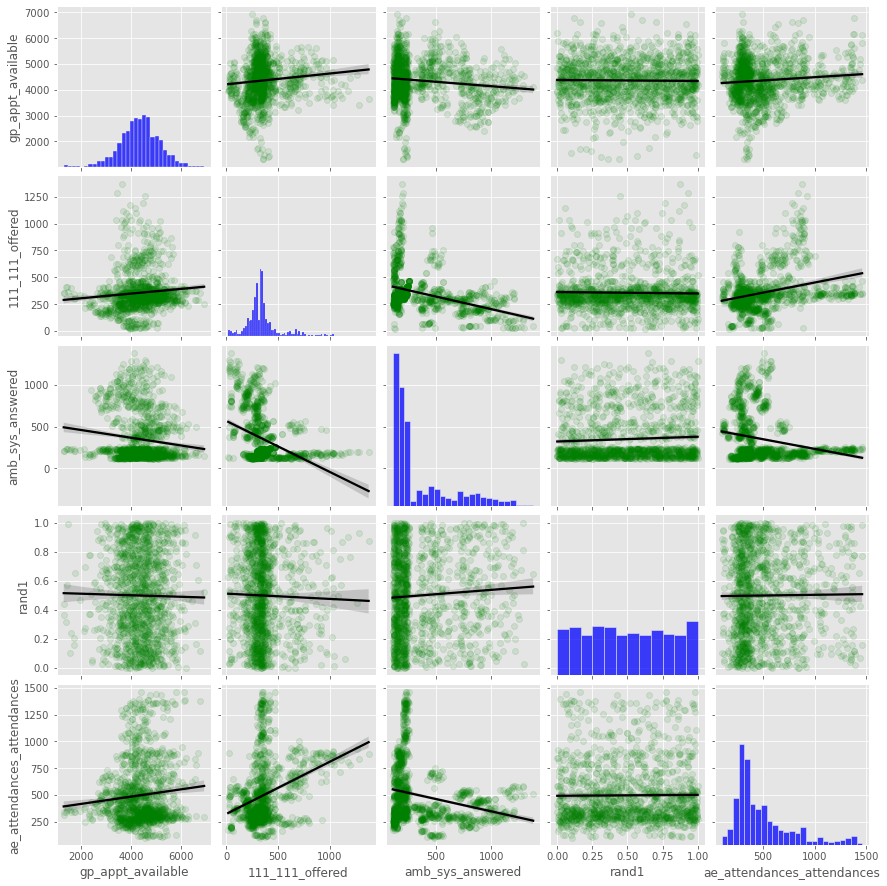

In [9]:
fig = sns.pairplot(dta[['gp_appt_available',
                        '111_111_offered', 'amb_sys_answered', 'rand1',
                        'ae_attendances_attendances']]\
                   .select_dtypes(include=np.number), 
                   kind="reg",
                   plot_kws={'line_kws':{'color':'black'}, 
                            'scatter_kws': 
                             {'color':'green','alpha': 0.1}},
                   diag_kws={'color':'blue'})

#plt.savefig('capacity_pair.png')

### Linear regression 

In [10]:
model = LinearRegression()

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.coef_)

#### Performance 

In [11]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [12]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.111536,0.104803
std,0.006269,0.024715
min,0.098526,0.055634
25%,0.108390,0.087104
50%,0.110441,0.106536
75%,0.115806,0.115970
max,0.124374,0.158852


#### Feature Importance 

In [13]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.019253,0.401340,-0.131060,22.532157
std,0.005392,0.012787,0.009303,14.046476
min,0.008642,0.383528,-0.149124,-1.041711
25%,0.015893,0.393374,-0.136238,13.079353
50%,0.018606,0.398643,-0.130400,22.422863
75%,0.023551,0.406297,-0.124300,31.309703
max,0.028418,0.434013,-0.114328,48.469443


### Random forest 

In [14]:
model = RandomForestRegressor(max_depth=5, n_estimators=5,
                              random_state=0)
#model = GradientBoostingRegressor(max_depth=5, n_estimators=5)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

#### Performance 

In [15]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [16]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.479554,0.401465
std,0.015109,0.045712
min,0.450552,0.290692
25%,0.469366,0.380714
50%,0.477193,0.401153
75%,0.491804,0.440482
max,0.515312,0.464827


#### Feature importance 

In [17]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.131311,0.303408,0.541905,0.023376
std,0.022639,0.061420,0.060134,0.008708
min,0.103803,0.204129,0.393577,0.009373
25%,0.115033,0.255388,0.518272,0.017304
50%,0.124122,0.298519,0.550371,0.020762
75%,0.145699,0.345932,0.587589,0.026498
max,0.187688,0.432466,0.629892,0.048022


### Gradient boosted tress

In [18]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=5, 
                                  random_state=1)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feats.append(model.feature_importances_)

#### Performance 

In [19]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [20]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.306473,0.273600
std,0.017052,0.020703
min,0.280220,0.236475
25%,0.290414,0.260914
50%,0.306815,0.272298
75%,0.319199,0.284838
max,0.336834,0.309368


#### Feature Importance 

In [21]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.129336,0.307546,0.552687,0.010431
std,0.028692,0.118265,0.095183,0.005255
min,0.079082,0.172479,0.432371,0.000184
25%,0.102111,0.194279,0.455372,0.006123
50%,0.131332,0.224471,0.603307,0.011596
75%,0.153300,0.423588,0.646426,0.013624
max,0.179190,0.470025,0.669316,0.023198


### Summary 

**Linear Regression**

- Very poor performance, mean $R^2$ ~ 0.1

**Random Forest**

- Best performance with mean $R^2$ = 0.4 in test data
- Feature importance is stable: ambulance capacity is most important, followed by 111 then GP capacity. 
- The random feature has low importnace

**Gradient Boosted Trees**

- Doesn't perform as well as a Random Forest, mean $R^2$ = 0.27 in test data
- Feature importance is in agreement with the Random Forest


## Hyper parameter tuning 

The best model is the Random Forest. To ensure the model is not over fit to the training data we compare performance when the following parameters are varied:

- max_depth: the maximum size of any tree 
- n_estimators: the number of trees in the forest

### Maximum depth

In [22]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, 
                                  n_estimators=4, random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

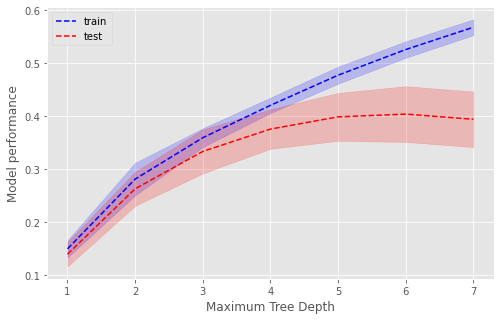

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Model performance')
plt.show()

A depth of 5 is optimal. After this, there is no improvement in performance on unseen data (test, red dashed line) and performance continues to increase in the training data (blue dashed line) suggesting overfitting.

### Number of trees

In [24]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=5, n_estimators=est,
                                  random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

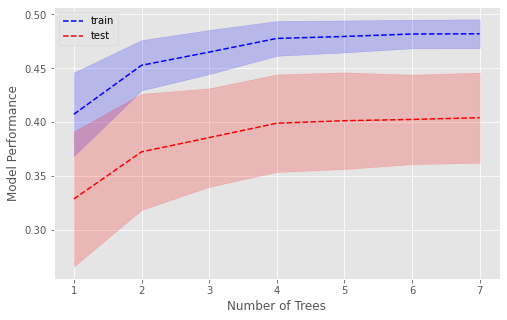

In [25]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Number of Trees')
plt.ylabel('Model Performance')

plt.show()

The optimal number of trees is 4, beyond which there is no improvement in the training or test set.

## Final Model

Fit the Random forest with optimal parameters

In [26]:
model = RandomForestRegressor(max_depth=5, n_estimators=4,
                              random_state=0)


features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

### Performance 

In [27]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [28]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.476443,0.409858
std,0.015873,0.047502
min,0.445223,0.295735
25%,0.466671,0.383160
50%,0.471313,0.414034
75%,0.493616,0.445741
max,0.505142,0.470831


### Feature Importance 

In [29]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered
count,25.000000,25.000000,25.000000
mean,0.145429,0.286520,0.568051
std,0.023150,0.076011,0.067739
min,0.112465,0.164935,0.407353
25%,0.131028,0.218329,0.531437
50%,0.139025,0.275405,0.580194
75%,0.161065,0.337680,0.611512
max,0.210084,0.444205,0.668179
